In [5]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [6]:
event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")

In [7]:
is_deteriorated("1001", "2101")

False

In [8]:
team = "オリオールズ"

In [9]:
#lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))

In [10]:
df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=4, how="own"))
lst = make_flattened_list(triple[:])
df = pd.DataFrame(lst)
score_diff = df[1].apply(lambda x: x[1])
df = df.applymap(lambda x: x[0])
df["得点"] = score_diff
df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]

In [32]:
event_df[event_df.攻撃チーム=="カブス"].head()

,状況,打順,打者,結果,アウト,裏得点,表得点,イニング,表裏,攻撃チーム
30348,0000,1,シュワバー,左フライ,1,0,0,1,裏,カブス
30349,1000,2,ブライアント,四球,1,0,0,1,裏,カブス
30350,1100,3,リゾ,右フライ,2,0,0,1,裏,カブス
30351,2100,4,ゾブリスト,見逃し三振,3,0,0,1,裏,カブス
30352,3000,1,NaN,NaN,NaN,0,0,1,裏,カブス


In [77]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [78]:
imp_list = []
det_list = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    imp_list.append(np.mean(improved_score_list))
    det_list.append(np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ブリュワーズ 1.82942589581 0.946072698121
カブス 1.12341609717 0.876937092662
ブルージェイズ 1.50872919605 1.01985066925
オリオールズ 1.86542104218 0.960262310013
レッズ 1.40846019932 0.82715877444
ツインズ 1.39918701953 0.842306335731
Rソックス 1.30982737849 0.819188972614
ブレーブス 1.27880759702 0.759568932936
ロッキーズ 1.88719126475 0.92113289828
パドレス 1.1194927535 0.895955108566
タイガース 1.28639718647 0.715798861343
カージナルス 1.38064927148 0.890158841389
マーリンズ 1.86824915894 0.800064418143
メッツ 1.42374978819 0.962482221972
マリナーズ 1.87008270554 0.902569233866
フィリーズ 1.23471734456 0.783229856355
パイレーツ 1.35251383129 0.631483711265
レンジャーズ 1.14533576548 0.970702274359
アスレチックス 1.98687241498 1.08381309416
Wソックス 2.08338100829 0.875830524006
エンゼルス 1.20198645342 0.948968721226
ヤンキース 1.82572305221 1.00319373951
ドジャース 1.91923638098 1.01325743801
インディアンス 1.72810198903 1.01632508776
ナショナルズ 1.76014733489 0.813545986586
ロイヤルズ 2.20180326219 0.790367630575
ジャイアンツ 0.882602478288 0.655131235304
Dバックス 1.80406127812 0.901758805464
レイズ 0.889645129887 0.91

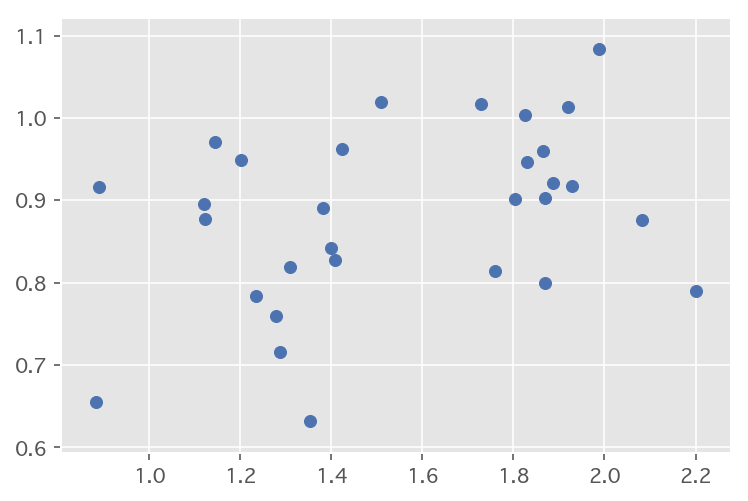

In [79]:
plt.scatter(imp_list, det_list)

In [96]:
from sklearn.cluster import KMeans

In [138]:
X = np.array([[elem1, elem2] for elem1, elem2 in zip(imp_list, det_list)])
model = KMeans(n_clusters=4)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [139]:
teams_mlb
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

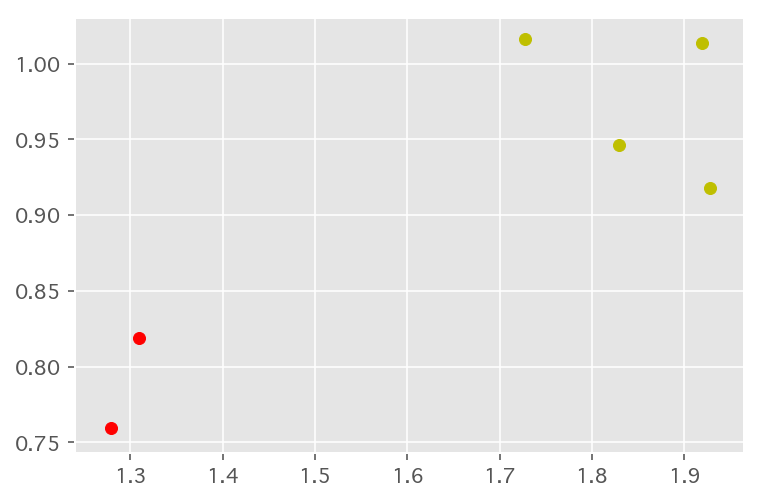

In [142]:
index_list = [teams_mlb.index(team) for team in first_teams]
colors = ["r", "y", "g", "b", "w", "k", "m", "c"]
labels = list(set(model.labels_))
for idx in index_list:
    for i in range(len(labels)):
        if model.labels_[idx] == labels[i]:
            plt.scatter([imp_list[idx]], [det_list[idx]], color=colors[i])

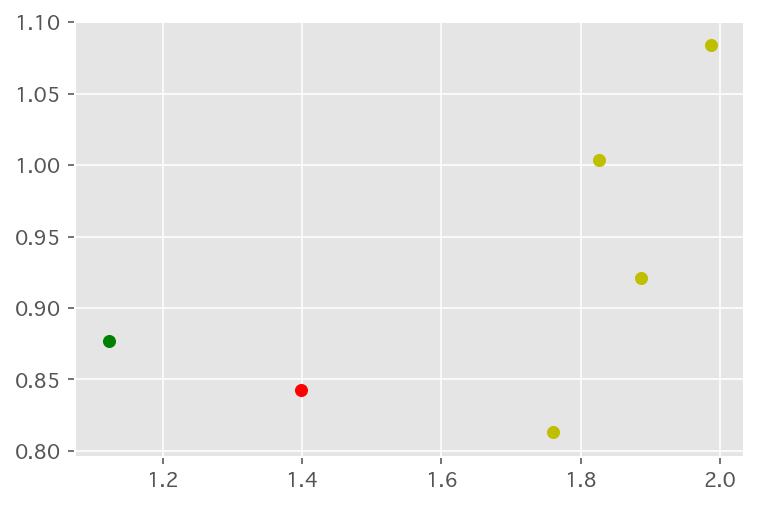

In [143]:
index_list = [teams_mlb.index(team) for team in second_teams]
colors = ["r", "y", "g", "b", "w", "k", "m", "c"]
labels = list(set(model.labels_))
for idx in index_list:
    for i in range(len(labels)):
        if model.labels_[idx] == labels[i]:
            plt.scatter([imp_list[idx]], [det_list[idx]], color=colors[i])

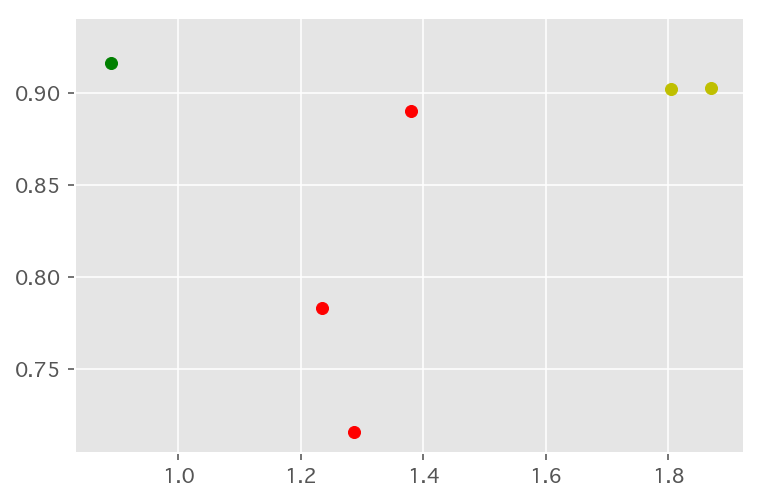

In [144]:
index_list = [teams_mlb.index(team) for team in third_teams]
colors = ["r", "y", "g", "b", "w", "k", "m", "c"]
labels = list(set(model.labels_))
for idx in index_list:
    for i in range(len(labels)):
        if model.labels_[idx] == labels[i]:
            plt.scatter([imp_list[idx]], [det_list[idx]], color=colors[i])

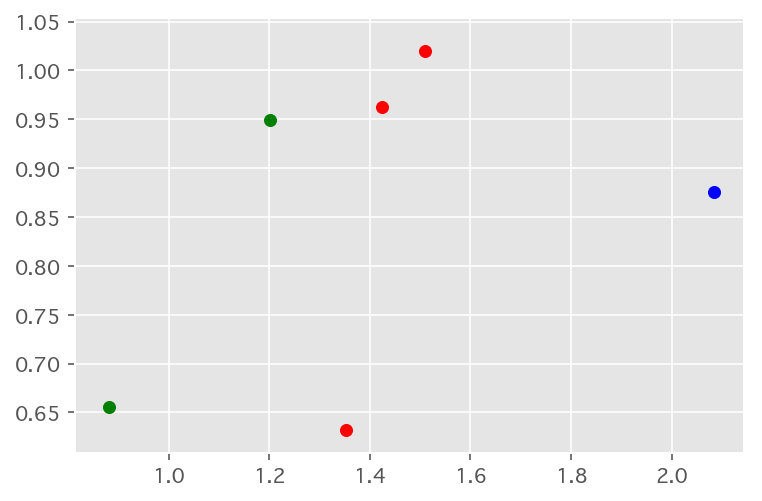

In [145]:
index_list = [teams_mlb.index(team) for team in fourth_teams]
colors = ["r", "y", "g", "b", "w", "k", "m", "c"]
labels = list(set(model.labels_))
for idx in index_list:
    for i in range(len(labels)):
        if model.labels_[idx] == labels[i]:
            plt.scatter([imp_list[idx]], [det_list[idx]], color=colors[i])

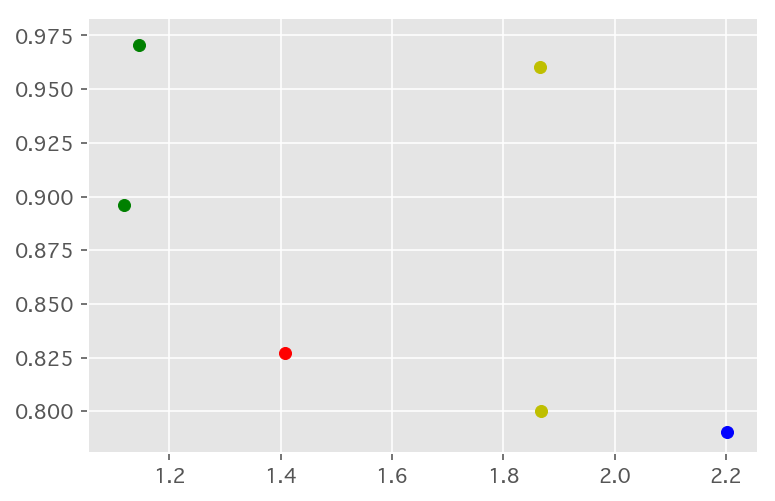

In [146]:
index_list = [teams_mlb.index(team) for team in fifth_teams]
colors = ["r", "y", "g", "b", "w", "k", "m", "c"]
labels = list(set(model.labels_))
for idx in index_list:
    for i in range(len(labels)):
        if model.labels_[idx] == labels[i]:
            plt.scatter([imp_list[idx]], [det_list[idx]], color=colors[i])

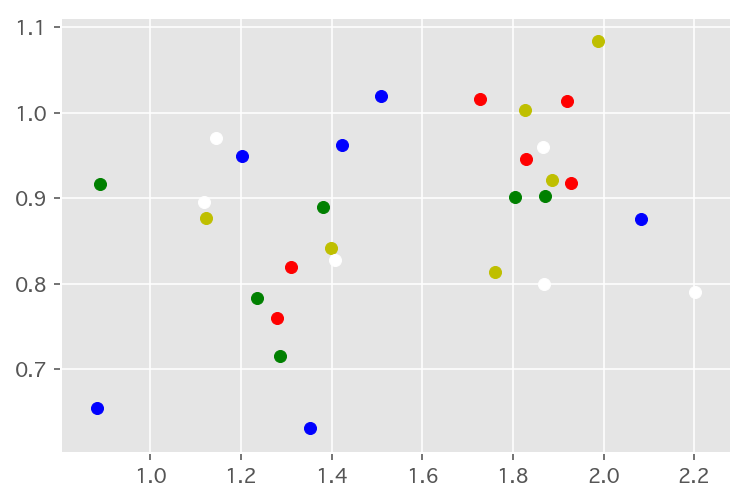

In [149]:
colors = ["r", "y", "g", "b", "w", "k", "m", "c"]
teams_list = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
for i in range(5):
    teams = teams_list[i]
    for team in teams:
        idx = teams_mlb.index(team)
        plt.scatter([imp_list[idx]], [det_list[idx]], color=colors[i])

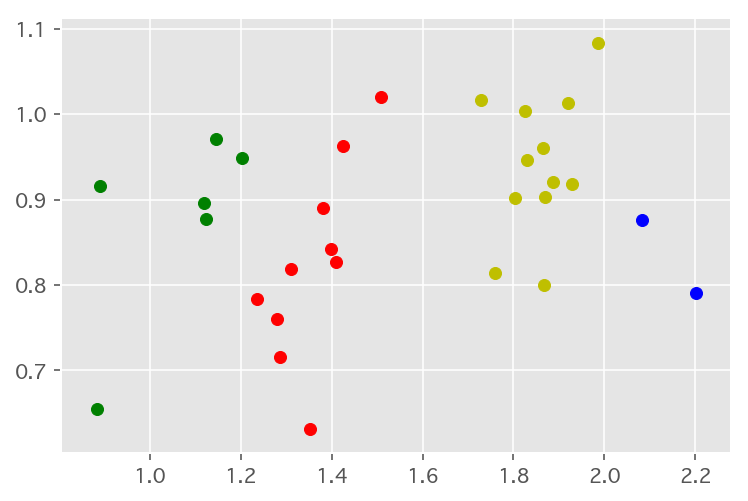

In [147]:
colors = ["r", "y", "g", "b", "w", "k", "m", "c"]
labels = list(set(model.labels_))
for idx in range(len(teams_mlb)):
    for i in range(len(labels)):
        if model.labels_[idx] == labels[i]:
            plt.scatter([imp_list[idx]], [det_list[idx]], color=colors[i])

In [12]:
imp_list = []
det_list = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(three_series[2][1]-three_series[1][1])
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(three_series[2][1]-three_series[1][1])
    imp_list.append(np.mean(improved_score_list))
    det_list.append(np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ブリュワーズ 0.188968335036 0.0694097288983
カブス 0.191205533597 0.0671140939597
ブルージェイズ 0.184628008753 0.069033530572
オリオールズ 0.184706213101 0.0648057778645
レッズ 0.1802295253 0.0668243642815
ツインズ 0.206652697748 0.0685065570562
Rソックス 0.219171483622 0.0708588388054
ブレーブス 0.202431289641 0.0630541871921
ロッキーズ 0.203027139875 0.0724925521351
パドレス 0.169626998224 0.0613845852128
タイガース 0.188611111111 0.0593941793704
カージナルス 0.197057277982 0.0688550840673
マーリンズ 0.183508488278 0.0663214499104
メッツ 0.177380634836 0.0712183637434
マリナーズ 0.19222462203 0.0679320679321
フィリーズ 0.182655826558 0.0617911615174
パイレーツ 0.189753320683 0.0565130260521
レンジャーズ 0.20204191295 0.0714428657194
アスレチックス 0.199946538359 0.0812734823018
Wソックス 0.176601053507 0.0676691729323
エンゼルス 0.186913307565 0.0723539964122
ヤンキース 0.219337937604 0.0771227289581
ドジャース 0.18979303857 0.0773361976369
インディアンス 0.204619633442 0.081976744186
ナショナルズ 0.203220858896 0.0683326825459
ロイヤルズ 0.186013590034 0.064548361311
ジャイアンツ 0.161058383664 0.0562599049128
Dバックス

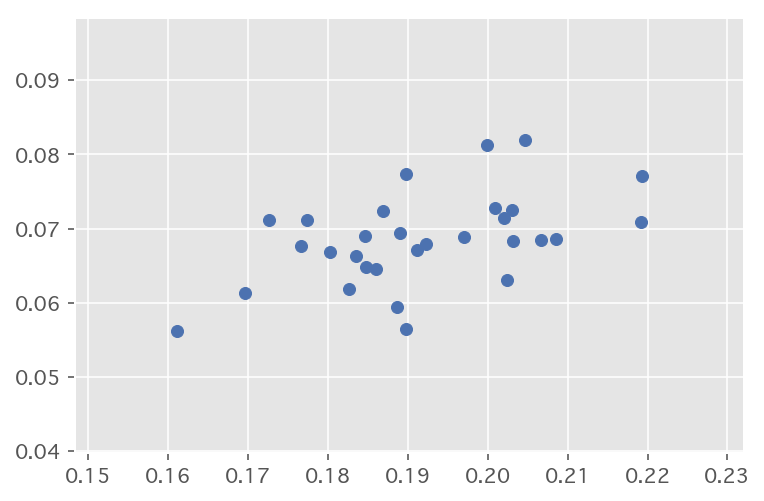

In [13]:
plt.scatter(imp_list, det_list)

In [14]:
improved_lst = [elem for elem in df_with_score[df_with_score.得点<=30][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1], "score")]

In [15]:
improved_score_list = []
deteriorated_score_list = []
for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
    if is_improved(three_series[0][0], three_series[1][0]):
        improved_score_list.append(three_series[2][1]-three_series[1][1])
    elif is_deteriorated(three_series[0][0], three_series[1][0]):
        deteriorated_score_list.append(three_series[2][1]-three_series[1][1])

In [16]:
np.mean(improved_score_list)

0.20094786729857819

In [17]:
np.mean(deteriorated_score_list)

0.072798361571401973

In [18]:
pd.Series(improved_score_list).value_counts()

0    3618
1     416
2     135
3      42
4       9
dtype: int64

In [19]:
pd.Series(deteriorated_score_list).value_counts()

0    5054
1     255
2      53
3       6
4       3
dtype: int64